## Uncertainty Quantifications - Monte Carlo Simulations

---

This notebook will quantify log k values for various species using a Monte Carlo method with lower and upper bounds from literature. See below:

Mahoney et al. (2009). Uranyl Adsorption on to Hydrous Ferric Oxcide--A Re-Evaluation for the Diffuse Layer Model Database. *Environmental Science and Technology,* *43*(24), 9263. doi: 10.1021/es901586w

#### Set up initial parameters and uncertainty bounds

*pqcpath*: path to phreeqc.bat executable

*TDBfile*: name of phreeqc database file without file extension

*outfile*: name of phreeqc output file including file extension

*infile*: name of phreeqc input file including file extension

In [3]:
import os 
import numpy.random
from writeIOphreeqc import*
import matplotlib.pyplot as plt

# these are used when we run phreeqc in run_sims()
pqcpath = 'C:/Users/htzen/Desktop/phreeqc-3.7.0-15749-x64/bin/phreeqc'
TDBfile = 'llnl_Mahoney_updated'
outfile = 'Outputfile3.out'
infile = 'U_HFO_input3.txt'

# bounds from table 2 in Mahoney et. al.
pars    = ['!Hfo_sOUO2+!', '!Hfo_wOUO2+!', '!Hfo_wOUO2CO3-!', '!Hfo_wOUO2(CO3)2-3!']
lower = [1.62, 1.79, 8.75, 15.1]
upper = [5.85, 3.28, 9.32, 15.28]

# setting up values from experimental results for later plotting
exp_pH = [3.56041,4.07969,4.51985,5.00029,5.47929,5.93959]
exp_U = [0.099831,0.071537,0.029899,0.001774,0,0]


# extraneous verify function which can be a simple sanity check for longer lists
def verify(low, upp):
    """
    checks length and bounds of lists for correct format
    """
    if len(low) == len(upp):
        
        if all([low[i] <= upp[i] for i in range(len(low))]):
            print("verify: bounds check out")
            return True
        print("verify: error -- listed bounds are inconsistent")
        return False
    
    print("verify: error -- lists are different lenghts")
    return False



# searches for the '-find ' key in the input file to get the name of the .sel output file
# (assumes .sel file is in the current directory)
def find_opsel(infile):
    
    with open(infile, 'r') as f:
        for line in f.readlines():
            if line.find("-file ") > 0:
                return line[line.find("-file ")+len("-file "):-1]
            
    print("error: unable to find output file in {}".format(infile))
    return -1

# verify bounds and set phreeqc output to read
verify(lower, upper)
opsel = find_opsel(infile)
#print(opsel)

verify: bounds check out


#### Define methods for Monte Carlo simulation

In a Monte Carlo simulation we will generate random values for the parameters within the upper/lower bounds for each run

In [4]:
# returns a matrix of random values between lower and upper
def get_random_values(lower, upper, num_iter):
    # lower, upper: lists of bounds to generate within
    # num_iter: number of sets to generate
    # return: num_iter by len(lower) matrix
    
    # generate 1st row
    matrix = np.zeros(len(lower))
    for i in range(len(lower)):
        matrix[i] = numpy.random.uniform(lower[i], upper[i])
        
    # generate more rows if needed
    if num_iter < 2:
        return [matrix]
    else:
        for j in range(num_iter-1):
            values = np.zeros(len(lower))
            for i in range(len(lower)):
                values[i] = numpy.random.uniform(lower[i], upper[i])
            matrix = np.vstack((matrix, values))
        return matrix

# runs a phreeqc simulation for each row of parameters in values_mtrx
# requires various path variables to be set correctly at beginning of file
def run_sims(values_mtrx, opsel, analytes=['pH', 'U']):
    # values_mtrx: matrix of values generated from get_random_values or similar function
    # analytes: list of element keywords to search for in .out file generated by phreeqc
    # opsel: path to the .sel file  
    # return: list of np arrays of [sim#, analyte1, analyte2...] (format is kind of awkward 
    #    but I can handle it with wrapper functions for now)
    
    obs_all = []
    for values in values_mtrx:        
        # enabling the below code can help verify phreeqc is correctly generating new output files
        # by deleting old output files before each run
#         if os.path.exists("Outputfile.out"):
#             os.remove("Outputfile.out")
#         if os.path.exists("U_HFO_Complexation_Output_Trial3.sel"):
#             os.remove("U_HFO_Complexation_Output_Trial3.sel")

        writeInput(TDBfile, pars, values)
        
        # the .read() here is essential because it tells python to wait for phreeqc to
        # finish running before executing following code.
        os.popen(pqcpath+' '+infile+' '+outfile+' '+TDBfile+'.txt').read()
        
        # reads phreeqc results and appends to running list
        obs = readOutput(opsel, analytes)
        obs_all.append(obs)

        # enabling following code can help check if the output files are updating correctly
#         import shutil
#         shutil.copyfile('U_HFO_Complexation_Output_Trial3.sel', 'U_HFO_Complexation_Output_Trial3_{}.sel'.format(itr))
#         shutil.copyfile('llnl_Mahoney_updated.txt', 'llnl_Mahoney_updated{}.txt'.format(itr))

    return obs_all


In [5]:
# This generates 100 random sets of parameters
# gen_values = get_random_values(lower, upper, 100)
# res = run_sims(gen_values, opsel)

In [6]:
# This loads a previous set of 100 parameters
# np.save("8_3_MC100gv.npy", gen_values)
# np.save("8_3_MC100res.npy", res)
gen_values = np.load("8_3_MC100gv.npy")
res = np.load("8_3_MC100res.npy")
res

array([[[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [7.7593e-08, 2.4536e-08, 4.3503e-09, 6.1775e-10, 1.4488e-10,
         8.0226e-11]],

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.9259e-08, 9.3331e-08, 6.6375e-08, 2.1268e-08, 5.9316e-09,
         3.3698e-09]],

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
         5.9400e+00],
        [9.8323e-08, 8.5132e-08, 4.4522e-08, 9.8863e-09, 2.4968e-09,
         1.3966e-09]],

       ...,

       [[1.0000e+00, 2.0000e+00, 3.0000e+00, 4.0000e+00, 5.0000e+00,
         6.0000e+00],
        [3.5600e+00, 4.0800e+00, 4.5200e+00, 5.0000e+00, 5.4800e+00,
  

#### Plotting + Residual Sum of Squares Analysis with Experimental Results

For each run from run_sims that we did we can plot pH vs Uranium concentrations in micromoles, and compare to experimental results to find the run with the least RSS value

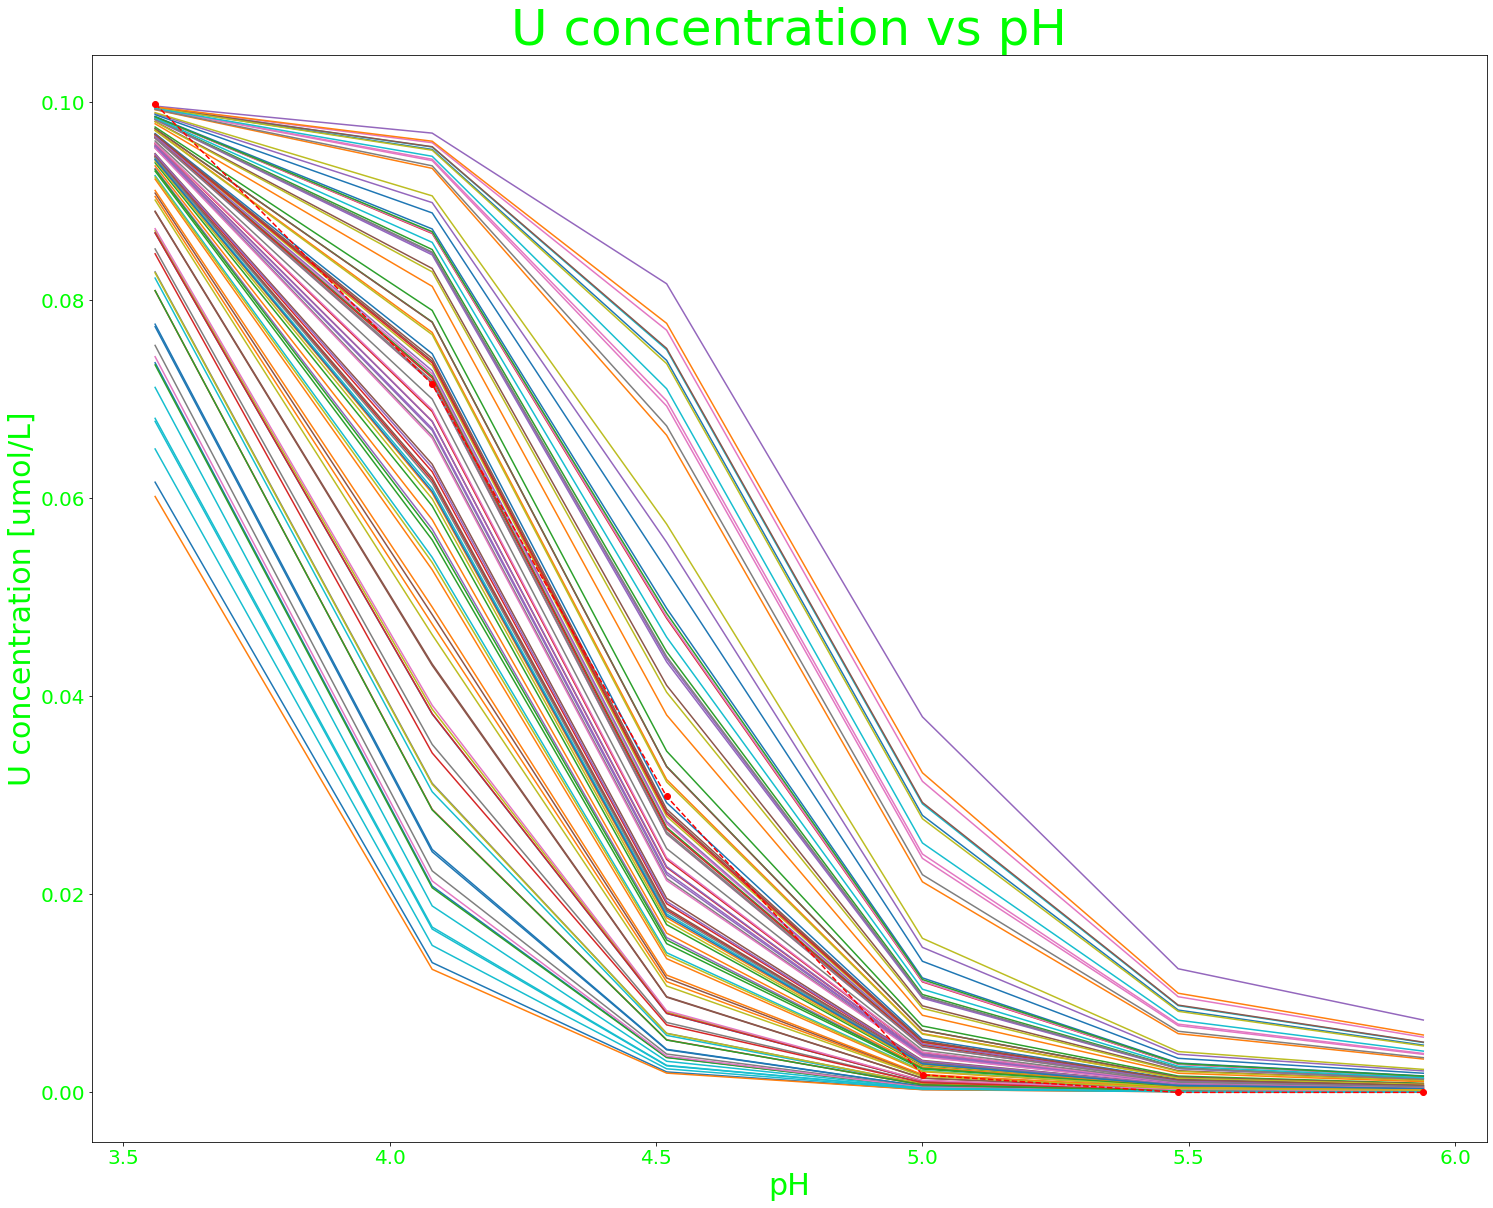

In [7]:
f = plt.figure(figsize=[25,20])

# setting plot colors so I can read the plot in a dark background notebook
plt.title("U concentration vs pH", fontdict={'fontsize': 50, 'color': 'lime'})
plt.xlabel('pH', fontdict={'fontsize': 30, 'color': 'lime'})
plt.xticks(fontsize = 20, color = 'lime')
plt.ylabel('U concentration [umol/L]', fontdict={'fontsize': 30, 'color': 'lime'})
plt.yticks(fontsize = 20, color = 'lime')

# plotting each result from run_sims
for run in res:
    plt.plot(run[1], run[2]*1e6)

# plotting experimental results for reference
plt.plot(exp_pH, exp_U, 'r--o')

plt.show()

For RSS analysis we can find the residual sum of squares $\Sigma((exp - obs)^2)$ of each run with the experimental U concentration to find the parameters which come closest to the experimental results

In [8]:
# Putting all RSS values in a list to find the minimum index
rss_list = []
for run in res:
    # rss is Sum((expected - observed)^2)
    rss = np.sum(np.square(exp_U - run[2]*1e6))
    rss_list.append(rss)

    
# extracting best analytes from the min index
min_idx = rss_list.index(min(rss_list))
bestconc = res[min_idx][2]
bestanalytes = gen_values[min_idx]

print(rss_list)
print(min(rss_list), min_idx)
print("The best fitting analytes are: {} from run {}.".format(bestanalytes, min_idx))

# write a new .tpl file with the best fit analyte values
writeInput(TDBfile, pars, bestanalytes, TDBfile+"_MCnew")

[0.003357723057177976, 0.0022323596626, 0.00047492413109, 0.0002248983878142002, 0.00042498110854000007, 0.0001993409255689999, 0.00381514564485, 0.00012015604968079983, 3.0147238929599963e-05, 0.002587835781145299, 0.005649901017287299, 0.0058487218606912625, 0.00010963556062839998, 0.0002566010337802002, 0.0004395830230099999, 0.00032006227813000007, 3.100707006760004e-05, 0.0004503873802399995, 0.0017155101683845003, 0.004799061836625079, 0.0017607388717288, 0.0006781247706093003, 0.0003561351917370002, 0.0006558295935, 0.0004611228010272001, 0.00024767584931439994, 0.0006644614612500001, 0.0024860885662538004, 0.0003276192676825001, 0.0005495450764600002, 0.0033934195210474, 0.0010252133762369004, 0.0005155330158052999, 8.842491135169987e-05, 0.0001075302241497001, 0.0009597231887245001, 0.00267271235454, 0.002060672784227, 0.0002935227725399998, 0.0034605843755600007, 0.0032803668588499988, 0.0003048978057652002, 7.84270824048999e-05, 0.0017578430304620001, 0.00010240359542600007,

We have extracted the best set of Monte Carlo results using residual sum of squares. We can use similar cost functions to identify the best results of methods other than Monte Carlo 

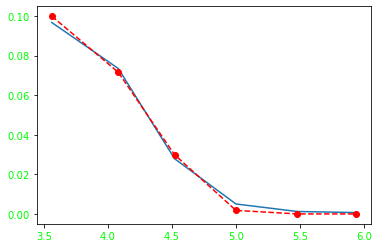

In [9]:
# brief plot of best Monte Carlo run vs the experimental results
plt.xticks(color = 'lime')
plt.yticks(color = 'lime')
plt.plot(res[0][1], bestconc*1e6, exp_pH, exp_U, 'r--o')
plt.show()